# Difference in Difference

The data is available at this [URL](https://github.com/KubiaPXH/Memoire-M1/raw/master/data/final_air_pollution_30cities.csv)

need to install lfe: https://cran.r-project.org/web/packages/lfe/lfe.pdf

In [1]:
library(tidyverse)
library(lfe)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



We get the data from Github and then we perform the following steps:

- import the data with the correct types
- covert character to factor
- Make sure of the level reference

In [2]:
url <- paste("https://raw.githubusercontent.com/KubiaPXH/Memoire-M1/",
"master/data/final_air_pollution_30cities.csv",  sep="")

In [3]:
df_ <- read_csv(url, col_types = cols(
  city = col_character(),
  year = col_character(),
  PM10 = col_double(),
  SO2 = col_double(),
  NOx = col_double(),
  pop_density = col_double(),
  GRP_pc = col_double(),
  second_industry = col_double(),
  gas_supply = col_double(),
  green_coveraged = col_double(),
  post = col_character(),
  key_regions = col_character())
               )  %>% 
mutate_if(is.character, as.factor) %>%
mutate(
    post = relevel(post, ref='0'),
    key_regions = relevel(key_regions, ref='0'),
    ## For explanation purpose. Kunming is not in key region
    city = relevel(city, ref='Kunming')
    
    )

In [4]:
glimpse(df_)

Observations: 300
Variables: 12
$ city            <fct> Beijing, Beijing, Beijing, Beijing, Beijing, Beijing,…
$ year            <fct> 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,…
$ PM10            <dbl> 123, 121, 121, 113, 109, 108, 116, 102, 92, 84, 88, 1…
$ SO2             <dbl> 36, 34, 32, 28, 29, 26, 22, 14, 10, 8, 61, 56, 54, 42…
$ NOx             <dbl> 49, 53, 57, 56, 52, 56, 57, 50, 48, 46, 41, 40, 45, 3…
$ pop_density     <dbl> 792.06, 759.14, 766.44, 778.69, 790.63, 802.08, 812.5…
$ GRP_pc          <dbl> 63029, 70452, 75943, 81658, 87475, 148181, 99995, 106…
$ second_industry <dbl> 25.68, 23.50, 24.01, 23.09, 22.70, 22.32, 21.31, 19.7…
$ gas_supply      <dbl> 601381, 682839, 719740, 729608, 924763, 989484, 11368…
$ green_coveraged <dbl> 37.15, 47.68, 55.10, 51.59, 51.92, 51.11, 60.41, 60.9…
$ post            <fct> 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,…
$ key_regions     <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…


In [5]:
colnames(df_)[ apply(df_, 2, anyNA)] 

character(0)

In [6]:
#df_ %>% group_by(city) %>% summarize(length(city))

In [7]:
#df_ %>% group_by(city, key_regions) %>% summarize(length(city))

In [8]:
#df_ %>% group_by(city, post) %>% summarize(length(city))

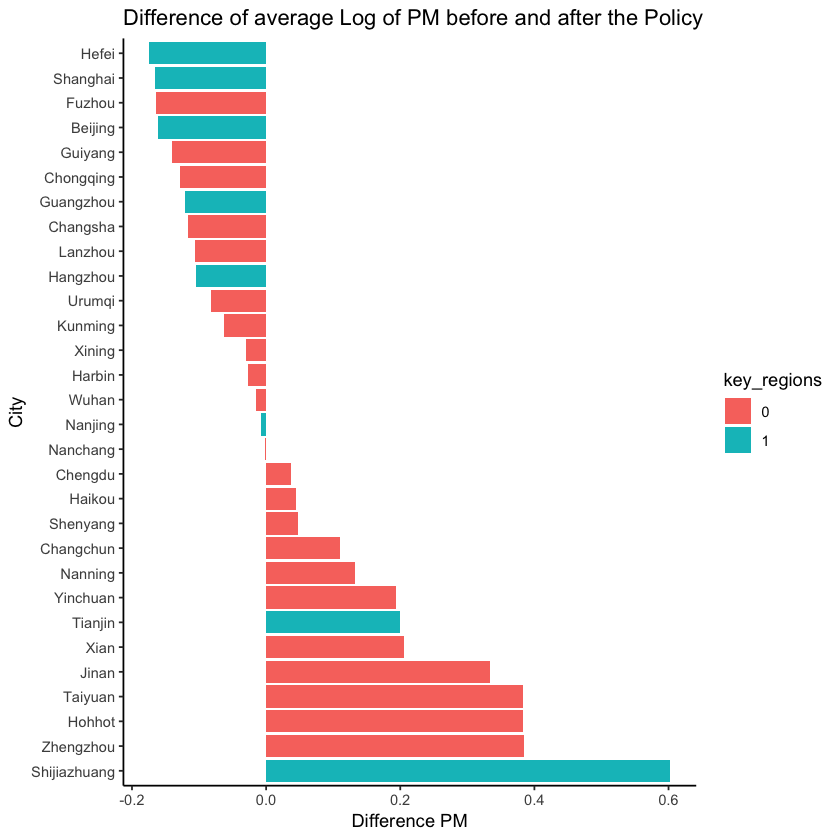

In [9]:
df_ %>% 
group_by(city, key_regions, post) %>% 
summarize(avg_pm = mean(log(PM10))) %>% 
spread(post, avg_pm, sep = "")%>%
mutate(diff  = post1 -post0 ) %>%
arrange(diff) %>%
ggplot(aes(x=reorder(city, -diff),y=diff, fill = key_regions))+ 
geom_bar(stat="identity")+ 
theme_classic()+ 
coord_flip()+ 
labs( x="City",
     y="Difference PM", 
     title =paste( "Difference of average Log of PM before and after the Policy" ) )

In [10]:
summary(df_)

        city          year          PM10             SO2        
 Kunming  : 10   2008   : 30   Min.   : 34.00   Min.   :  5.00  
 Beijing  : 10   2009   : 30   1st Qu.: 78.00   1st Qu.: 20.00  
 Changchun: 10   2010   : 30   Median : 98.00   Median : 34.00  
 Changsha : 10   2011   : 30   Mean   : 99.55   Mean   : 35.85  
 Chengdu  : 10   2012   : 30   3rd Qu.:116.00   3rd Qu.: 49.00  
 Chongqing: 10   2013   : 30   Max.   :305.00   Max.   :105.00  
 (Other)  :240   (Other):120                                    
      NOx         pop_density         GRP_pc       second_industry
 Min.   :12.00   Min.   : 130.2   Min.   : 18025   Min.   :18.14  
 1st Qu.:36.00   1st Qu.: 324.7   1st Qu.: 45667   1st Qu.:37.48  
 Median :44.00   Median : 560.5   Median : 63464   Median :44.28  
 Mean   :42.67   Mean   : 635.2   Mean   : 67856   Mean   :42.88  
 3rd Qu.:51.00   3rd Qu.: 813.5   3rd Qu.: 83848   3rd Qu.:49.85  
 Max.   :68.00   Max.   :2294.6   Max.   :185338   Max.   :60.13  
           

# Define the model


## Test without FE

$$ \text{ln PM 10}_{ci} = \alpha Post + \beta \text{ key region}+ \alpha Post \times \text{key region} + \epsilon_{ct}$$

For the sake of the tutorial, we don't cluster the standard error -> We want to make sure we get the same results 

In [11]:
df_ %>% summarize( mean(log(PM10)))

mean(log(PM10))
<dbl>
4.550635


In [12]:
model <- log(PM10) ~ post +  key_regions + post:key_regions
fit <- lm(model, df_)
summary(fit)


Call:
lm(formula = model, data = df_)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.98671 -0.19728  0.03103  0.19646  1.14850 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         4.51307    0.03074 146.809   <2e-16 ***
post1               0.06284    0.04347   1.445    0.149    
key_regions1        0.05021    0.05953   0.843    0.400    
post1:key_regions1 -0.05430    0.08419  -0.645    0.519    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3224 on 296 degrees of freedom
Multiple R-squared:  0.008053,	Adjusted R-squared:  -0.002 
F-statistic: 0.801 on 3 and 296 DF,  p-value: 0.4941


In [13]:
model <- log(PM10) ~ post * key_regions 
fit <- lm(model, df_)
summary(fit)


Call:
lm(formula = model, data = df_)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.98671 -0.19728  0.03103  0.19646  1.14850 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         4.51307    0.03074 146.809   <2e-16 ***
post1               0.06284    0.04347   1.445    0.149    
key_regions1        0.05021    0.05953   0.843    0.400    
post1:key_regions1 -0.05430    0.08419  -0.645    0.519    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3224 on 296 degrees of freedom
Multiple R-squared:  0.008053,	Adjusted R-squared:  -0.002 
F-statistic: 0.801 on 3 and 296 DF,  p-value: 0.4941


With the FE library

In [14]:
summary(felm(formula=log(PM10) ~ post +  key_regions + post : key_regions  |
             FALSE | 0 |FALSE, data = df_, exactDOF=TRUE))


Call:
   felm(formula = log(PM10) ~ post + key_regions + post:key_regions |      FALSE | 0 | FALSE, data = df_, exactDOF = TRUE) 

Residuals:
     Min       1Q   Median       3Q      Max 
-0.98671 -0.19728  0.03103  0.19646  1.14850 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         4.51307    0.03074 146.809   <2e-16 ***
post1               0.06284    0.04347   1.445    0.149    
key_regions1        0.05021    0.05953   0.843    0.400    
post1:key_regions1 -0.05430    0.08419  -0.645    0.519    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3224 on 296 degrees of freedom
Multiple R-squared(full model): 0.008053   Adjusted R-squared: -0.002 
Multiple R-squared(proj model): 0.008053   Adjusted R-squared: -0.002 
F-statistic(full model):0.801 on 3 and 296 DF, p-value: 0.4941 
F-statistic(proj model): 0.801 on 3 and 296 DF, p-value: 0.4941 



In [15]:
summary(felm(formula=log(PM10) ~  post * key_regions  |
             FALSE | 0 |FALSE, data = df_, exactDOF=TRUE))


Call:
   felm(formula = log(PM10) ~ post * key_regions | FALSE | 0 | FALSE,      data = df_, exactDOF = TRUE) 

Residuals:
     Min       1Q   Median       3Q      Max 
-0.98671 -0.19728  0.03103  0.19646  1.14850 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         4.51307    0.03074 146.809   <2e-16 ***
post1               0.06284    0.04347   1.445    0.149    
key_regions1        0.05021    0.05953   0.843    0.400    
post1:key_regions1 -0.05430    0.08419  -0.645    0.519    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3224 on 296 degrees of freedom
Multiple R-squared(full model): 0.008053   Adjusted R-squared: -0.002 
Multiple R-squared(proj model): 0.008053   Adjusted R-squared: -0.002 
F-statistic(full model):0.801 on 3 and 296 DF, p-value: 0.4941 
F-statistic(proj model): 0.801 on 3 and 296 DF, p-value: 0.4941 



## Test with FE

We add city fixed effect. It leads therefore to singularities with the interaction term. We should expect that the coefficient `key_regions1` to be dropped 

$$ \text{ln PM 10}_{ci} = \alpha Post + \alpha Post \times \text{key region}+ \gamma_c + \epsilon_{ct}$$

For the sake of the tutorial, we don't cluster the standard error -> We want to make sure we get the same results 



In [16]:
summary(lm(log(PM10) ~ post + key_regions + post:key_regions +city, df_))


Call:
lm(formula = log(PM10) ~ post + key_regions + post:key_regions + 
    city, data = df_)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.36726 -0.10996  0.01471  0.09337  0.78220 

Coefficients: (1 not defined because of singularities)
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         4.14993    0.05362  77.388  < 2e-16 ***
post1               0.06284    0.02236   2.810 0.005323 ** 
key_regions1        0.51426    0.07727   6.656 1.59e-10 ***
cityBeijing         0.01513    0.07417   0.204 0.838565    
cityChangchun       0.36834    0.07417   4.966 1.22e-06 ***
cityChangsha        0.24275    0.07417   3.273 0.001205 ** 
cityChengdu         0.52705    0.07417   7.106 1.08e-11 ***
cityChongqing       0.34961    0.07417   4.714 3.92e-06 ***
cityFuzhou         -0.05507    0.07417  -0.743 0.458423    
cityGuangzhou      -0.48615    0.07417  -6.554 2.85e-10 ***
cityGuiyang         0.08615    0.07417   1.161 0.246480    
cityHaikou         -0.493

In [17]:
summary(lm(log(PM10) ~ post*key_regions+city, df_))


Call:
lm(formula = log(PM10) ~ post * key_regions + city, data = df_)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.36726 -0.10996  0.01471  0.09337  0.78220 

Coefficients: (1 not defined because of singularities)
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         4.14993    0.05362  77.388  < 2e-16 ***
post1               0.06284    0.02236   2.810 0.005323 ** 
key_regions1        0.51426    0.07727   6.656 1.59e-10 ***
cityBeijing         0.01513    0.07417   0.204 0.838565    
cityChangchun       0.36834    0.07417   4.966 1.22e-06 ***
cityChangsha        0.24275    0.07417   3.273 0.001205 ** 
cityChengdu         0.52705    0.07417   7.106 1.08e-11 ***
cityChongqing       0.34961    0.07417   4.714 3.92e-06 ***
cityFuzhou         -0.05507    0.07417  -0.743 0.458423    
cityGuangzhou      -0.48615    0.07417  -6.554 2.85e-10 ***
cityGuiyang         0.08615    0.07417   1.161 0.246480    
cityHaikou         -0.49347    0.07417  -6.653 1.

In [18]:
4.14993 - 4.21276

[1] -0.06283

In [19]:
df_ <- read_csv(url, col_types = cols(
  city = col_character(),
  year = col_character(),
  PM10 = col_double(),
  SO2 = col_double(),
  NOx = col_double(),
  pop_density = col_double(),
  GRP_pc = col_double(),
  second_industry = col_double(),
  gas_supply = col_double(),
  green_coveraged = col_double(),
  post = col_character(),
  key_regions = col_character())
               )  %>% 
mutate_if(is.character, as.factor) %>%
mutate(
    post = relevel(post, ref='1'),
    key_regions = relevel(key_regions, ref='0'),
    ## For explanation purpose. Kunming is not in key region
    city = relevel(city, ref='Kunming')
    
    )
summary(lm(log(PM10) ~ post + post:key_regions+city - 1, df_))


Call:
lm(formula = log(PM10) ~ post + post:key_regions + city - 1, 
    data = df_)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.36726 -0.10996  0.01471  0.09337  0.78220 

Coefficients: (1 not defined because of singularities)
                   Estimate Std. Error t value Pr(>|t|)    
post1               4.21276    0.05362  78.560  < 2e-16 ***
post0               4.14993    0.05362  77.388  < 2e-16 ***
cityBeijing         0.52938    0.07727   6.851 5.00e-11 ***
cityChangchun       0.36834    0.07417   4.966 1.22e-06 ***
cityChangsha        0.24275    0.07417   3.273 0.001205 ** 
cityChengdu         0.52705    0.07417   7.106 1.08e-11 ***
cityChongqing       0.34961    0.07417   4.714 3.92e-06 ***
cityFuzhou         -0.05507    0.07417  -0.743 0.458423    
cityGuangzhou       0.02811    0.07727   0.364 0.716261    
cityGuiyang         0.08615    0.07417   1.161 0.246480    
cityHaikou         -0.49347    0.07417  -6.653 1.61e-10 ***
cityHangzhou        0.36539    0.07

In [20]:
df_ <- read_csv(url, col_types = cols(
  city = col_character(),
  year = col_character(),
  PM10 = col_double(),
  SO2 = col_double(),
  NOx = col_double(),
  pop_density = col_double(),
  GRP_pc = col_double(),
  second_industry = col_double(),
  gas_supply = col_double(),
  green_coveraged = col_double(),
  post = col_character(),
  key_regions = col_character())
               )  %>% 
mutate_if(is.character, as.factor) %>%
mutate(
    post = relevel(post, ref='0'),
    key_regions = relevel(key_regions, ref='0'),
    ## For explanation purpose. Kunming is not in key region
    city = relevel(city, ref='Kunming')
    
    )

summary(felm(formula=log(PM10) ~  post * key_regions  |
             city | 0 |FALSE, data = df_, exactDOF=TRUE))

Warning message in chol.default(mat, pivot = TRUE, tol = tol):
“the matrix is either rank-deficient or indefinite”Warning message in chol.default(mat, pivot = TRUE, tol = tol):
“the matrix is either rank-deficient or indefinite”


Call:
   felm(formula = log(PM10) ~ post * key_regions | city | 0 | FALSE,      data = df_, exactDOF = TRUE) 

Residuals:
     Min       1Q   Median       3Q      Max 
-0.36726 -0.10996  0.01471  0.09337  0.78220 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)   
post1               0.06284    0.02236   2.810  0.00532 **
key_regions1             NA         NA      NA       NA   
post1:key_regions1 -0.05430    0.04331  -1.254  0.21097   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1658 on 268 degrees of freedom
Multiple R-squared(full model): 0.7624   Adjusted R-squared: 0.7349 
Multiple R-squared(proj model): 0.0288   Adjusted R-squared: -0.08354 
F-statistic(full model):27.73 on 31 and 268 DF, p-value: < 2.2e-16 
F-statistic(proj model): 2.649 on 3 and 268 DF, p-value: 0.04929 



## Add control

$$ \text{ln PM 10}_{ci} = \alpha Post + \beta \text{ key region}+ \alpha Post \times \text{key region} + X_{ct} + \gamma_c + \epsilon_{ct}$$

In [21]:
summary(felm(formula=log(PM10) ~ post *  key_regions + 
             log(pop_density)|
             city| 0 |FALSE, data = df_, exactDOF=TRUE))

Warning message in chol.default(mat, pivot = TRUE, tol = tol):
“the matrix is either rank-deficient or indefinite”Warning message in chol.default(mat, pivot = TRUE, tol = tol):
“the matrix is either rank-deficient or indefinite”


Call:
   felm(formula = log(PM10) ~ post * key_regions + log(pop_density) |      city | 0 | FALSE, data = df_, exactDOF = TRUE) 

Residuals:
     Min       1Q   Median       3Q      Max 
-0.36589 -0.10981  0.01475  0.09331  0.78586 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)  
post1               0.06131    0.02391   2.564   0.0109 *
key_regions1             NA         NA      NA       NA  
log(pop_density)    0.04050    0.22273   0.182   0.8558  
post1:key_regions1 -0.05471    0.04344  -1.259   0.2090  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1661 on 267 degrees of freedom
Multiple R-squared(full model): 0.7624   Adjusted R-squared: 0.7339 
Multiple R-squared(proj model): 0.02892   Adjusted R-squared: -0.08746 
F-statistic(full model):26.77 on 32 and 267 DF, p-value: < 2.2e-16 
F-statistic(proj model): 1.988 on 4 and 267 DF, p-value: 0.09664 



In [22]:
summary(felm(formula=log(PM10) ~ post *  key_regions + 
             log(pop_density) + log(GRP_pc)|
             city| 0 |FALSE, data = df_, exactDOF=TRUE))

Warning message in chol.default(mat, pivot = TRUE, tol = tol):
“the matrix is either rank-deficient or indefinite”Warning message in chol.default(mat, pivot = TRUE, tol = tol):
“the matrix is either rank-deficient or indefinite”


Call:
   felm(formula = log(PM10) ~ post * key_regions + log(pop_density) +      log(GRP_pc) | city | 0 | FALSE, data = df_, exactDOF = TRUE) 

Residuals:
     Min       1Q   Median       3Q      Max 
-0.33171 -0.09778  0.01066  0.08897  0.76707 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
post1               0.22958    0.03576   6.419 6.26e-10 ***
key_regions1             NA         NA      NA       NA    
log(pop_density)    0.28913    0.21324   1.356   0.1763    
log(GRP_pc)        -0.31937    0.05282  -6.046 4.99e-09 ***
post1:key_regions1 -0.08291    0.04108  -2.018   0.0446 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1561 on 266 degrees of freedom
Multiple R-squared(full model): 0.7911   Adjusted R-squared: 0.7652 
Multiple R-squared(proj model): 0.1463   Adjusted R-squared: 0.04035 
F-statistic(full model):30.52 on 33 and 266 DF, p-value: < 2.2e-16 
F-statistic(proj model): 9.114 on 5 and 266 

In [23]:
summary(felm(formula=log(PM10) ~ post *  key_regions + 
             log(pop_density) + log(GRP_pc) + log(second_industry)|
             city| 0 |FALSE, data = df_, exactDOF=TRUE))

Warning message in chol.default(mat, pivot = TRUE, tol = tol):
“the matrix is either rank-deficient or indefinite”Warning message in chol.default(mat, pivot = TRUE, tol = tol):
“the matrix is either rank-deficient or indefinite”


Call:
   felm(formula = log(PM10) ~ post * key_regions + log(pop_density) +      log(GRP_pc) + log(second_industry) | city | 0 | FALSE, data = df_,      exactDOF = TRUE) 

Residuals:
     Min       1Q   Median       3Q      Max 
-0.37832 -0.09241  0.01356  0.08580  0.69664 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
post1                 0.29206    0.03441   8.488 1.52e-15 ***
key_regions1               NA         NA      NA       NA    
log(pop_density)      0.29511    0.19751   1.494    0.136    
log(GRP_pc)          -0.28323    0.04922  -5.755 2.39e-08 ***
log(second_industry)  0.73860    0.11005   6.712 1.16e-10 ***
post1:key_regions1   -0.05392    0.03829  -1.408    0.160    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1446 on 265 degrees of freedom
Multiple R-squared(full model): 0.8214   Adjusted R-squared: 0.7985 
Multiple R-squared(proj model): 0.2703   Adjusted R-squared: 0.1767 
F-statistic